## 8) Train a LinearSVC on a linearly separable dataset. Then train an SVC and a SGDClassifier on the same dataset. See if you can get them to produce roughly the same model. (iris dataset)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

### Data Prep

In [2]:
iris = datasets.load_iris()
X = iris["data"][:, (2,3)] # petal length and petal width
y = iris["target"]

# Iris Setosa and Iris Versicolor classes are linearly separable.
setosa_or_versi = (y == 0) | (y == 1) 
X = X[setosa_or_versi]
y = y[setosa_or_versi]

In [3]:
# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Training

In [4]:
# Train a LinearSVC
linear_svc_clf = LinearSVC(C=1, loss="hinge",random_state=42)
linear_svc_clf.fit(X_scaled,y)
print("LinearSVC intercept, coef:",linear_svc_clf.intercept_,linear_svc_clf.coef_)

LinearSVC intercept, coef: [0.29588877] [[1.0607458  1.00177835]]


In [5]:
# Train a SVC
svc_clf = SVC(C=1, kernel="linear", random_state=42)
svc_clf.fit(X_scaled, y)
print("SVC intercept, coef:",svc_clf.intercept_,svc_clf.coef_)

SVC intercept, coef: [0.32182521] [[1.04342638 0.94747825]]


In [6]:
# Train a SGDClassifier
# alpha = 1/(m*C)
alpha = 1 / len(X_scaled) * 1
sgd_clf = SGDClassifier(loss = "hinge", alpha = alpha, random_state=42)
sgd_clf.fit(X_scaled, y)
print("SVC intercept, coef:",sgd_clf.intercept_,sgd_clf.coef_)

SVC intercept, coef: [0.25786715] [[1.22997122 1.01887836]]


### Plotting decision boundaries

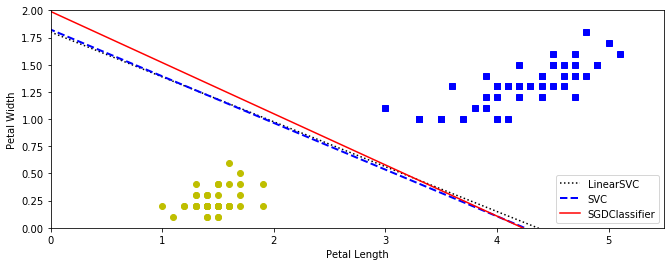

In [7]:
# Compute the slope and bias of each decision boundary
w_lin = -linear_svc_clf.coef_[0, 0]/linear_svc_clf.coef_[0, 1]
b_lin = -linear_svc_clf.intercept_[0]/linear_svc_clf.coef_[0, 1]
w_svc = -svc_clf.coef_[0, 0]/svc_clf.coef_[0, 1]
b_svc = -svc_clf.intercept_[0]/svc_clf.coef_[0, 1]
w_sgd= -sgd_clf.coef_[0, 0]/sgd_clf.coef_[0, 1]
b_sgd = -sgd_clf.intercept_[0]/sgd_clf.coef_[0, 1]

# Transform the decision boundary lines back to the original scale
line_lin = scaler.inverse_transform([[-10, -10 * w_lin + b_lin], [10, 10 * w_lin + b_lin]])
line_svc = scaler.inverse_transform([[-10, -10 * w_svc + b_svc], [10, 10 * w_svc + b_svc]])
line_sgd = scaler.inverse_transform([[-10, -10 * w_sgd + b_sgd], [10, 10 * w_sgd + b_sgd]])

plt.figure(figsize=(11, 4))
plt.plot(line_lin[:, 0], line_lin[:, 1], "k:", label="LinearSVC")
plt.plot(line_svc[:, 0], line_svc[:, 1], "b--", linewidth=2, label="SVC")
plt.plot(line_sgd[:, 0], line_sgd[:, 1], "r-", label="SGDClassifier")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs") # label="Iris versicolor"
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo") # label="Iris setosa"
plt.xlabel("Petal Length", fontsize=10)
plt.ylabel("Petal Width", fontsize=10)
plt.legend(loc="lower right", fontsize=10)
plt.axis([0, 5.5, 0, 2])

plt.show()

## 9) Train an SVM classifier on the MNIST dataset. Since SVM classifiers are binary classifiers, you will need to use one-versus-all to classify all 10 digits. You may want to tune the hyperparameters using small validation sets to speed up the process. What accuracy can you reach?

### Data Prep

In [8]:
# Loading MNIST
mnist = datasets.fetch_openml('mnist_784', version=1)
X = mnist["data"]
y = mnist["target"]

# Data is already splitted into training and test sets and shuffled
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

In [9]:
# SVM classifier will automatically use the One-vs-All.
# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32))
X_test_scaled = scaler.transform(X_test.astype(np.float32))

### LinearSVC

In [10]:
# Training LinearSVC
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_train_scaled, y_train)

C:\Users\esra\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)

In [11]:
# Predict and evaluate on training set
y_pred = lin_clf.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.9218166666666666

### SVC

In [12]:
svm_clf = SVC(gamma="scale")
svm_clf.fit(X_train_scaled, y_train) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [13]:
# Predict and evaluate on training set
y_pred = svm_clf.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.9866333333333334

### Hyperparameter tuning

In [15]:
# Randomized Search CV 
param_distribs = {"C": uniform(1,10), "gamma": reciprocal(0.001, 0.1)}

random_search = RandomizedSearchCV(svm_clf, param_distribs, n_iter=10, verbose=2,cv=3)
random_search.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] C=7.540121673030702, gamma=0.049397861486246274 .................
[CV] . C=7.540121673030702, gamma=0.049397861486246274, total=123.1min
[CV] C=7.540121673030702, gamma=0.049397861486246274 .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 123.1min remaining:    0.0s


[CV] . C=7.540121673030702, gamma=0.049397861486246274, total=121.4min
[CV] C=7.540121673030702, gamma=0.049397861486246274 .................
[CV] . C=7.540121673030702, gamma=0.049397861486246274, total=122.4min
[CV] C=5.677304672860501, gamma=0.004134507926617371 .................
[CV] .. C=5.677304672860501, gamma=0.004134507926617371, total=20.0min
[CV] C=5.677304672860501, gamma=0.004134507926617371 .................
[CV] .. C=5.677304672860501, gamma=0.004134507926617371, total=20.0min
[CV] C=5.677304672860501, gamma=0.004134507926617371 .................
[CV] .. C=5.677304672860501, gamma=0.004134507926617371, total=19.7min
[CV] C=8.594997867690171, gamma=0.001564950554585664 .................
[CV] .. C=8.594997867690171, gamma=0.001564950554585664, total=10.2min
[CV] C=8.594997867690171, gamma=0.001564950554585664 .................
[CV] .. C=8.594997867690171, gamma=0.001564950554585664, total=10.2min
[CV] C=8.594997867690171, gamma=0.001564950554585664 .................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 1789.1min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=SVC(C=1.0, cache_size=200, class_weight=None,
                                 coef0=0.0, decision_function_shape='ovr',
                                 degree=3, gamma='scale', kernel='rbf',
                                 max_iter=-1, probability=False,
                                 random_state=None, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001E9CED50A08>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001E9CED508C8>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=2)

In [16]:
best_model = random_search.best_estimator_
# Predict and evaluate on training set
y_pred = best_model.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.9994

In [17]:
# Predict and evaluate on test set
y_pred = best_model.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

0.9723